In [143]:
# Notebook 4\5

In [144]:
# 25.8.24 Feature Eng and Feature selection
# אגריגציות והוספת נתונים חדשים במידת הצורך
# שיקוף יחסי נתונים ותובנות באמצעות גרפים (יחסים בין נתונים, ענן מילים)
# מומלץ להריץ מודל unsupervised כשמדובר בפרויקט classification  - i dont have clasification 
# Feature selection  ע”י מודלים לניבוי Lasso, Ridge - Lasso 
# One-Hot Encoding (Label encoding)  - Done 
# אם רלוונטי לפרויקט imbalanced data - במקרה של משתנה מטרה בינארי ביחס של 20% או פחות -  i dont have 


In [145]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [146]:
# Linear relations between sentiment & subjectivity to target param 
# the pair is: process_overview_df. then plot it with: plot_popularity_scatter
#  1
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from numpy.linalg import lstsq
from textblob import TextBlob

def analyze_sentiment_subjectivity(text):
    if isinstance(text, str):
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    else:
        return 0.0, 0.0

def calculate_weights(sentiment, subjectivity, popularity):
    """
    Calculate weights for sentiment and subjectivity to match given popularity.
    """
    # we need that the row will be an observation and the columns will be feature 1 ...n 
    # basically if matrix is already align we can use merge or joing . it is common to use stack and the .T to get the same order as the original DF was in our case.
    X = np.vstack([sentiment, subjectivity, np.ones(len(sentiment))]).T
    y = popularity
    
    # Use least-squares to find the coefficients
    w, _, _, _ = lstsq(X, y, rcond=None)
    
    return w[0], w[1], w[2]

def process_overview_df(df_overview, tar_column_name):
    if tar_column_name not in df_overview.columns:
        raise ValueError(f"Column '{tar_column_name}' not found in DataFrame")

    df_processed = df_overview.copy()

    # Analyze sentiment and subjectivity
    sentiments_subjectivities = df_processed[tar_column_name].apply(analyze_sentiment_subjectivity)
    sentiments_df = pd.DataFrame(sentiments_subjectivities.tolist(), columns=['sentiment', 'subjectivity'], index=df_processed.index)
    df_processed[['sentiment', 'subjectivity']] = sentiments_df

    # Remove rows with missing overview, 0.0 popularity, or 0.0 sentiment/subjectivity
    df_processed = df_processed.dropna(subset=[tar_column_name])
    df_processed = df_processed[(df_processed['popularity'] != 0.0) & 
                                (df_processed['sentiment'] != 0.0) & 
                                (df_processed['subjectivity'] != 0.0)]
    
    # Scale popularity
    scaler = MinMaxScaler()
    df_processed['popularity'] = scaler.fit_transform(df_processed[['popularity']])
    
    # Calculate weights
    w1, w2, b = calculate_weights(df_processed['sentiment'], df_processed['subjectivity'], df_processed['popularity'])
    
    # Calculate calc_popularity using the derived weights
    df_processed['calc_popularity'] = w1 * df_processed['sentiment'] + w2 * df_processed['subjectivity'] + b
    
    # Print the calculated weights
    print(f"Calculated Weights - w1 (Sentiment): {w1}, w2 (Subjectivity): {w2}, Intercept: {b}")
    
    df_processed.reset_index(inplace=True)
    df_processed.rename(columns={'index': 'Id'}, inplace=True)
    df_processed = df_processed[['Id', tar_column_name, 'sentiment', 'subjectivity', 'calc_popularity', 'popularity']]
    
    return df_processed

def plot_distributions(df_processed):
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(df_processed['popularity'], bins=30, alpha=0.5, label='Popularity', color='blue')
    plt.hist(df_processed['calc_popularity'], bins=30, alpha=0.5, label='Calc Popularity', color='orange')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.title('Distribution of Popularity and Calculated Popularity')
    plt.legend()
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.scatter(df_processed['popularity'], df_processed['calc_popularity'], alpha=0.5, color='blue', label='Data points')
    z = np.polyfit(df_processed['popularity'], df_processed['calc_popularity'], 1)
    p = np.poly1d(z)
    plt.plot(df_processed['popularity'], p(df_processed['popularity']), color='red', linestyle='--', label='Trend line')
    plt.xlabel('Popularity')
    plt.ylabel('Calculated Popularity')
    plt.title('Scatter Plot of Calculated Popularity vs Popularity')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()




In [147]:
# Polynomial Regression Model
# Purpose: To fit a linear model to the transformed polynomial features, allowing the model to capture non-linear relationships.


# Linear Regression on Polynomial Features:
# Once you have the polynomial features ( X_{\text{poly}} ), you fit a linear regression model:
# y^​=Xpoly​β
# where ( \beta ) are the coefficients of the model.


# Model Fitting:
# The linear regression model finds the best-fitting coefficients ( \beta ) that minimize the difference between the predicted values ( \hat{y} ) and the actual target values ( y ).


# Prediction:
# Using the fitted model, you can make predictions on new data by transforming the new data into polynomial features and applying the linear model:
# y^​new​=Xpoly, new​β


# Why Use Polynomial Features?

# Capture Non-Linearity: Polynomial features allow the model to capture complex, non-linear relationships between the features and the target variable.
# Flexibility: By adjusting the degree ( d ), you can control the complexity of the model. Higher degrees can capture more intricate patterns but may also lead to overfitting.

In [148]:
# Linear relations between sentiment & subjectivity to target param 
# the pair is: process_overview_df. then plot it with: plot_popularity_scatter
#  2

import matplotlib.pyplot as plt
import numpy as np

# I want to check if there is a linear relation -there isn't
def plot_popularity_scatter(df_processed):
    """
    Plot a scatter plot of 'calc_popularity' versus 'popularity' with a trend line.
    Assumes that 'df_processed' contains both columns.
    """
    # Check if the required columns exist in the DataFrame
    if 'calc_popularity' not in df_processed.columns or 'popularity' not in df_processed.columns:
        raise ValueError("DataFrame must contain 'calc_popularity' and 'popularity' columns")

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_processed['popularity'], df_processed['calc_popularity'], alpha=0.5, color='blue', label='Data points')
    
    # Add a trend line
    z = np.polyfit(df_processed['popularity'], df_processed['calc_popularity'], 1)
    p = np.poly1d(z)
    plt.plot(df_processed['popularity'], p(df_processed['popularity']), color='red', linestyle='--', label='Trend line')
    
    # Adding labels and title
    plt.xlabel('Popularity')
    plt.ylabel('Calculated Popularity')
    plt.title('Scatter Plot of Calculated Popularity vs Popularity')
    
    # Add a legend and grid
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()


In [149]:
# polynomial relations between sentiment & subjectivity to target param 
# the pair is: process_overview_df. then plot it with: plot_popularity_scatter_with_poly
#  1


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# I want to check if there is a polynomial relation -there isn't
def analyze_sentiment_subjectivity(text):
    if isinstance(text, str):
        blob = TextBlob(text)
        return blob.sentiment.polarity, blob.sentiment.subjectivity
    else:
        return 0.0, 0.0

def process_overview_df_with_polynomial(df_overview, tar_column_name, degree=3):
    if tar_column_name not in df_overview.columns:
        raise ValueError(f"Column '{tar_column_name}' not found in DataFrame")

    df_processed = df_overview.copy()

    # Analyze sentiment and subjectivity
    sentiments_subjectivities = df_processed[tar_column_name].apply(analyze_sentiment_subjectivity)
    sentiments_df = pd.DataFrame(sentiments_subjectivities.tolist(), columns=['sentiment', 'subjectivity'], index=df_processed.index)
    df_processed[['sentiment', 'subjectivity']] = sentiments_df

    # Remove rows with missing overview, 0.0 popularity, or 0.0 sentiment/subjectivity
    df_processed = df_processed.dropna(subset=[tar_column_name])
    df_processed = df_processed[(df_processed['popularity'] != 0.0) & 
                                (df_processed['sentiment'] != 0.0) & 
                                (df_processed['subjectivity'] != 0.0)]

    # Prepare features and target
    X = df_processed[['sentiment', 'subjectivity']]
    y = df_processed['popularity']

    # Polynomial feature transformation
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(X)

    # Fit polynomial regression model
    poly_model = LinearRegression()
    poly_model.fit(X_poly, y)

    # Predict and add polynomial-based predictions to DataFrame
    df_processed['poly_calc_popularity'] = poly_model.predict(X_poly)

    # Calculate the mean squared error
    y_pred_poly = poly_model.predict(X_poly)
    mse_poly = mean_squared_error(y, y_pred_poly)
    print(f"Polynomial Regression Mean Squared Error: {mse_poly}")

    # Return updated DataFrame
    return df_processed


# polynomial relations between sentiment & subjectivity to target param 
# the pair is: process_overview_df. then plot it with: plot_popularity_scatter_with_poly
#  2


def plot_popularity_scatter_with_poly(df_processed):
    """
    Plot a scatter plot of 'poly_calc_popularity' versus 'popularity' with a trend line.
    Assumes that 'df_processed' contains both columns.
    """
    # Check if the required columns exist in the DataFrame
    if 'poly_calc_popularity' not in df_processed.columns or 'popularity' not in df_processed.columns:
        raise ValueError("DataFrame must contain 'poly_calc_popularity' and 'popularity' columns")

    # Create the scatter plot
    plt.figure(figsize=(10, 6))
    plt.scatter(df_processed['popularity'], df_processed['poly_calc_popularity'], alpha=0.5, color='blue', label='Data points')
    
    # Add a trend line
    z = np.polyfit(df_processed['popularity'], df_processed['poly_calc_popularity'], 1)
    p = np.poly1d(z)
    plt.plot(df_processed['popularity'], p(df_processed['popularity']), color='red', linestyle='--', label='Trend line')
    
    # Adding labels and title
    plt.xlabel('Popularity')
    plt.ylabel('Polynomial Calculated Popularity')
    plt.title('Scatter Plot of Polynomial Calculated Popularity vs Popularity')
    
    # Add a legend and grid
    plt.legend()
    plt.grid(True)
    
    # Display the plot
    plt.show()




In [150]:
# import pandas as pd
# from textblob import TextBlob
# """
# Define the Main Function:
# This function will take the DataFrame,the target column name, 
# and return a new DataFrame with the desired columns.

# Define Sub-functions: These will include:
# analyze_sentiment_subjectivity: To analyze sentiment and subjectivity.
# calculate_popularity: To compute popularity (for demonstration, we will assume popularity is derived from the sentiment score for simplicity).
# """

# def analyze_sentiment_subjectivity(text):
#     """
#     Analyze sentiment and subjectivity of the given text.
#     Returns a tuple of (sentiment, subjectivity).
#     Handles non-string values by converting them to default values.
#     """
#     if isinstance(text, str):
#         blob = TextBlob(text)
#         return blob.sentiment.polarity, blob.sentiment.subjectivity
#     else:
#         # Handle non-string values (e.g., NaN or numeric) by returning default values
#         return 0.0, 0.0

# def calculate_calc_popularity(sentiment):
#     """
#     Calculate the calculated popularity based on sentiment score.
#     For simplicity, let's assume popularity is directly related to sentiment.
#     """
#     # Example: Popularity score can be scaled version of sentiment.
#     # Adjust scaling as needed.
#     return sentiment * 100

# def process_overview_dfOLD(df_overview, tar_column_name):
#     """
#     Process the DataFrame to add sentiment, subjectivity, and calculated popularity columns.
#     Uses DataFrame index as 'Id'.
#     """
#     # Check if the target column exists
#     if tar_column_name not in df_overview.columns:
#         raise ValueError(f"Column '{tar_column_name}' not found in DataFrame")

    
#     df_processed = df_overview.copy()

#     # option 1
#     # Calculate sentiment and subjectivity
#     df_processed[['sentiment', 'subjectivity']] = df_processed[tar_column_name].apply(lambda x: pd.Series(analyze_sentiment_subjectivity(x)))

#     # # option 2
#     # # Creating a DataFrame directly from a Series with custom column and index
#     # sentiments_df = pd.DataFrame(df_processed[tar_column_name].apply(analyze_sentiment_subjectivity).tolist(), 
#     #                          columns=['sentiment', 'subjectivity'], 
#     #                          index=df_processed.index)

#     # df_processed[['sentiment', 'subjectivity']] = sentiments_df

#     # #option 3
#     # # Create a list of tuples (sentiment, subjectivity) from the target column for comprehensive 
#     # sentiments_subjectivities = [analyze_sentiment_subjectivity(text) for text in df_processed[tar_column_name]]
    
#     # # Assign the extracted sentiment and subjectivity to the original DataFrame
#     # df_processed[['sentiment', 'subjectivity']] = pd.DataFrame(sentiments_subjectivities, columns=['sentiment', 'subjectivity'], index=df_processed.index)
    
    
#     # Calculate calculated popularity
#     df_processed['calc_popularity'] = df_processed['sentiment'].apply(calculate_calc_popularity)
    
#     # Reset the index to include it as a column
#     df_processed.reset_index(inplace=True)
#     df_processed.rename(columns={'index': 'Id'}, inplace=True)

#     # Select and order the columns, including the DataFrame index as 'Id'
#     df_processed = df_processedOLD[['Id', tar_column_name, 'sentiment', 'subjectivity', 'calc_popularity', 'popularity']]
    
#     return df_processed


In [151]:
import pandas as pd
from sklearn.linear_model import Lasso, Ridge
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

def validate_features(df, target_feature, features, alpha=1.0):
    """
    Validate features using Lasso and Ridge regression models.
    """
    X = df[features]
    y = df[target_feature]
    
    # Feature Scaling
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Initialize models
    lasso = Lasso(alpha=alpha)
    ridge = Ridge(alpha=alpha)
    
    # Fit models
    lasso.fit(X_scaled, y)
    ridge.fit(X_scaled, y)
    
    # Get selected features
    lasso_selected_features = [features[i] for i in range(len(lasso.coef_)) if lasso.coef_[i] != 0]
    ridge_selected_features = [features[i] for i in range(len(ridge.coef_)) if ridge.coef_[i] != 0]
    
    # Predict and calculate MSE
    y_pred_lasso = lasso.predict(X_scaled)
    y_pred_ridge = ridge.predict(X_scaled)
    
    mse_lasso = mean_squared_error(y, y_pred_lasso)
    mse_ridge = mean_squared_error(y, y_pred_ridge)
    
    # Create DataFrame for selected features
    lasso_features_df = pd.DataFrame({
        'Feature': features,
        'Lasso Selected': [feature in lasso_selected_features for feature in features],
        'Ridge Selected': [feature in ridge_selected_features for feature in features]
    })
    
    # Create DataFrame for MSE results
    mse_df = pd.DataFrame({
        'Model': ['Lasso', 'Ridge'],
        'MSE': [mse_lasso, mse_ridge]
    })
    
    return lasso_features_df, mse_df

In [152]:
import pandas as pd
import numpy as np
from scipy.stats import normaltest

def analyze_features(df):
    """
    Analyzes features in a DataFrame to determine their type (categorical/discrete numeric or continuous numeric),
    and provides recommended feature selection methods based on their distribution.

    Parameters:
    df (pd.DataFrame): The DataFrame containing the features to analyze.

    Returns:
    pd.DataFrame: A DataFrame with analysis results and recommended methods.
    """
    # Initialize results DataFrame
    results = pd.DataFrame({
        'Feature': df.columns,
        'DType': df.dtypes,
        'Analysis Result': '',
        'Recommended Method': ''
    })

    def get_recommended_methods(dtype, distribution, is_categorical):
        """
        Determines the recommended feature selection methods based on data type, distribution, and whether the data is categorical.

        Parameters:
        dtype (str): The data type of the feature.
        distribution (str): The distribution type ('Normal' or 'Non-Normal').
        is_categorical (bool): Whether the feature is categorical.

        Returns:
        tuple: Recommended methods for analysis and feature selection.
        """
        if distribution == 'Normal':
            if is_categorical:
                return 'Chi-Square Test, Logistic Regression', 'Decision Trees, Random Forests, MCA'
            else:
                return 'ANOVA, T-Test, Pearson’s Correlation', 'PCA, Lasso Regression, Ridge Regression'
        else:  # Non-Normal
            if is_categorical:
                return 'Fisher’s Exact Test, Logistic Regression', 'Decision Trees, Random Forests'
            else:
                return 'Kruskal-Wallis Test, Mann-Whitney U Test, Spearman’s Rank Correlation', 'PCA, ICA, Lasso Regression, Ridge Regression'

    for feature in df.columns:
        dtype = results.loc[results['Feature'] == feature, 'DType'].values[0]
        is_categorical = False
        distribution = 'Normal'

        # Handle features with 'Encoded' prefix/suffix or 'category' in the name
        if 'Encoded' in feature or 'category' in feature:
            is_categorical = True
        else:
            if pd.api.types.is_numeric_dtype(dtype):
                # Check distribution for non-categorical numeric features
                try:
                    _, p_value = normaltest(df[feature].dropna())
                    distribution = 'Normal' if p_value > 0.05 else 'Non-Normal'
                except Exception as e:
                    print(f"Error testing normality for {feature}: {e}")
                    distribution = 'Non-Normal'
            elif pd.api.types.is_categorical_dtype(dtype) or pd.api.types.is_object_dtype(dtype):
                is_categorical = True

        # Ensure consistency between dtype and analysis result
        if is_categorical:
            analysis_result = 'Categorical'
        else:
            analysis_result = 'Continuous Numeric' if distribution == 'Normal' else 'Non-Normal Continuous Numeric'
        
        results.loc[results['Feature'] == feature, 'Analysis Result'] = analysis_result
        results.loc[results['Feature'] == feature, 'DType'] = dtype
        # Assign Recommended Method
        rec_method = get_recommended_methods(dtype, distribution, is_categorical)
        results.loc[results['Feature'] == feature, 'Recommended Method'] = rec_method[0] if is_categorical else rec_method[1]

    return results


In [153]:
import pandas as pd

def calculate_pearson(df, target_feature):
    """
    NUMERIC - NORMAL
    Calculate Pearson correlation coefficient between all continuous numeric features
    and the target feature in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_feature (str): The name of the target feature (continuous).

    Returns:
    - pd.DataFrame: DataFrame with Pearson correlation coefficients for each feature.
    """
    # Ensure the target feature is numeric
    if not pd.api.types.is_numeric_dtype(df[target_feature]):
        raise ValueError(f"Target feature '{target_feature}' must be a numeric type.")
    
    # Select continuous numeric columns (excluding the target feature)
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_columns = [col for col in numeric_columns if col != target_feature]
    
    # Calculate Pearson correlation
    pearson_corr = df[numeric_columns].corrwith(df[target_feature])
    
    # Create a DataFrame for better readability
    pearson_df = pd.DataFrame({
        'Feature': pearson_corr.index,
        'Pearson_Correlation': pearson_corr.values
    })
    
    # Sort by the absolute value of the correlation coefficient
    pearson_df['Absolute_Correlation'] = pearson_df['Pearson_Correlation'].abs()
    pearson_df = pearson_df.sort_values(by='Absolute_Correlation', ascending=False).reset_index(drop=True)
    pearson_df.drop(columns='Absolute_Correlation', inplace=True)
    
    return pearson_df

# Example usage:
# Assuming 'df' is your DataFrame and 'target_feature' is the name of your target column
# pearson_results_df = calculate_pearson(df, 'target_feature')




In [154]:
import pandas as pd

def calculate_spearman(df, target_feature):
    """
    NUMERIC - NON NORMAL 
    Calculate Spearman rank correlation coefficient between all continuous numeric features
    and the target feature in a DataFrame.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_feature (str): The name of the target feature (continuous).

    Returns:
    - pd.DataFrame: DataFrame with Spearman correlation coefficients for each feature.
    """
    # Ensure the target feature is numeric
    if not pd.api.types.is_numeric_dtype(df[target_feature]):
        raise ValueError(f"Target feature '{target_feature}' must be a numeric type.")
    
    # Select continuous numeric columns (excluding the target feature)
    numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns
    numeric_columns = [col for col in numeric_columns if col != target_feature]
    
    # Calculate Spearman correlation
    spearman_corr = df[numeric_columns].corrwith(df[target_feature], method='spearman')
    
    # Create a DataFrame for better readability
    spearman_df = pd.DataFrame({
        'Feature': spearman_corr.index,
        'Spearman_Correlation': spearman_corr.values
    })
    
    # Sort by the absolute value of the correlation coefficient
    spearman_df['Absolute_Correlation'] = spearman_df['Spearman_Correlation'].abs()
    spearman_df = spearman_df.sort_values(by='Absolute_Correlation', ascending=False).reset_index(drop=True)
    spearman_df.drop(columns='Absolute_Correlation', inplace=True)
    
    return spearman_df

# Example usage:
# Assuming 'df' is your DataFrame and 'target_feature' is the name of your target column
# spearman_results_df = calculate_spearman(df, 'target_feature')


In [155]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt

def perform_pca(df, target_feature):
    """
    Perform PCA on the DataFrame and assess the importance of each principal component.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_feature (str): The name of the target feature (continuous) for correlation analysis.

    Returns:
    - pd.DataFrame: DataFrame with Principal Component, Explained Variance Ratio, and Cumulative Variance Ratio.
    """
    def normalize_features(X):
        """
        Normalize numerical features for PCA.
        """
        scaler = StandardScaler()
        return scaler.fit_transform(X)

    def compute_pca(X_scaled):
        """
        Perform PCA on scaled features and return PCA results.
        """
        pca = PCA()
        pca.fit(X_scaled)
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)
        return pca, explained_variance_ratio, cumulative_variance_ratio

    def print_pca_results(pca, explained_variance_ratio, cumulative_variance_ratio, numerical_columns):
        """
        Print PCA results and loadings.
        """
        pca_results = pd.DataFrame({
            'Principal Component': [f'PC{i+1}' for i in range(len(explained_variance_ratio))],
            'Explained Variance Ratio': explained_variance_ratio,
            'Cumulative Variance Ratio': cumulative_variance_ratio
        })

        # Principal Component Loadings
        loadings = pd.DataFrame(pca.components_.T, index=numerical_columns, columns=pca_results['Principal Component'])
        
        # Print PCA results and loadings
        print("PCA Results:")
        print(pca_results)
        print("\nPrincipal Component Loadings:")
        print(loadings)
        
        return pca_results, loadings

    def plot_pca(X_scaled, pca_results):
        """
        Plot the first two principal components.
        """
        X_pca = pd.DataFrame(pca.transform(X_scaled), columns=pca_results['Principal Component'])
        plt.figure(figsize=(10, 6))
        plt.scatter(X_pca['PC1'], X_pca['PC2'])
        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('PCA: PC1 vs PC2')
        plt.show()

    # Define the continuous target variable
    y = df[target_feature]
    
    # Identify the numerical columns for PCA
    numerical_columns = df.select_dtypes(include=['int', 'float']).columns
    
    # Exclude the target feature from the numerical columns
    numerical_columns = [col for col in numerical_columns if col != target_feature]

    # Extract numerical features
    X = df[numerical_columns]

    # Check for missing values
    if X.isnull().values.any() or y.isnull().values.any():
        print("Handling missing values...")
        # Handle missing values: Fill missing values with mean for numerical features
        X = X.fillna(X.mean())
        # Ensure target variable does not contain NaNs and align with X
        y = y.dropna()
        X = X.loc[y.index]

    # Normalize features for PCA
    X_scaled = normalize_features(X)

    # Perform PCA and get results
    pca, explained_variance_ratio, cumulative_variance_ratio = compute_pca(X_scaled)

    # Print PCA results and loadings
    pca_results, loadings = print_pca_results(pca, explained_variance_ratio, cumulative_variance_ratio, numerical_columns)

    # Plot PCA
    plot_pca(X_scaled, pca_results)

    return pca_results

# Example usage:
# df = pd.read_csv('your_data.csv')  # Load your data here
# target_feature = 'your_target_feature'  # Specify your target feature
# pca_results_df = perform_pca(df, target_feature)


In [156]:
# import pandas as pd
# from scipy.stats import kruskal

# def calculate_kruskal_wallis(df, target_feature):
#     """

#     Target feature  must be a categorical type. !!!
    
#     Perform Kruskal-Wallis Test to assess if there are significant differences 
#     between the groups in the target feature with respect to other categorical features.

#     Parameters:
#     - df (pd.DataFrame): The DataFrame containing the data.
#     - target_feature (str): The name of the target feature (categorical) for Kruskal-Wallis Test.

#     Returns:
#     - pd.DataFrame: DataFrame with Kruskal-Wallis H-Statistic and p-Value for each feature.
#     """
#     # Ensure the target feature is categorical
#     if not pd.api.types.is_categorical_dtype(df[target_feature]):
#         raise ValueError(f"Target feature '{target_feature}' must be a categorical type.")
    
#     # Identify the categorical columns for Kruskal-Wallis Test
#     categorical_columns = df.select_dtypes(include=['object', 'category']).columns
#     categorical_columns = [col for col in categorical_columns if col != target_feature]
    
#     # Prepare the results list
#     results = []
    
#     # Perform Kruskal-Wallis Test for each categorical feature
#     for feature in categorical_columns:
#         # Group data by the categorical feature
#         grouped_data = df.groupby(feature)[target_feature]
#         groups = [group for name, group in grouped_data]
        
#         # Perform Kruskal-Wallis Test
#         H_stat, p_value = kruskal(*groups)
        
#         # Append results
#         results.append({
#             'Feature': feature,
#             'Kruskal-Wallis H-Statistic': H_stat,
#             'p-Value': p_value
#         })
    
#     # Create a DataFrame to view results
#     kruskal_df = pd.DataFrame(results)
    
#     # Sort by H-Statistic
#     kruskal_df = kruskal_df.sort_values(by='Kruskal-Wallis H-Statistic', ascending=False).reset_index(drop=True)
    
#     return kruskal_df

# # Example usage:
# # Assuming 'df' is your DataFrame and 'target_feature' is the name of your target categorical column
# # kruskal_results_df = calculate_kruskal_wallis(df, 'target_feature')


In [157]:
import pandas as pd
from scipy.stats import mannwhitneyu

def find_group_feature(df, target_feature):
    """
    Dynamically identify a suitable group feature that has exactly two unique values 
    from the DataFrame for the Mann-Whitney U Test.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_feature (str): The name of the target feature (continuous) for Mann-Whitney U Test.

    Returns:
    - str: The name of the group feature with exactly two unique values.
    """
    # Ensure the target feature is continuous
    if not pd.api.types.is_numeric_dtype(df[target_feature]):
        raise ValueError(f"Target feature '{target_feature}' must be a numeric type.")
    
    # Identify categorical features
    categorical_features = df.select_dtypes(include=['object', 'category']).columns
    
    # Find a categorical feature with exactly two unique values
    for feature in categorical_features:
        if len(df[feature].unique()) == 2:
            return feature
    
    raise ValueError("No suitable group feature with exactly two unique values found.")

def calculate_mann_whitney(df, target_feature):
    """
    Perform Mann-Whitney U Test using a dynamically identified group feature 
    to assess if there are significant differences between two independent groups 
    in the target feature.

    Parameters:
    - df (pd.DataFrame): The DataFrame containing the data.
    - target_feature (str): The name of the target feature (continuous) for Mann-Whitney U Test.

    Returns:
    - pd.DataFrame: DataFrame with Mann-Whitney U Statistic and p-Value.
    """
    # Identify a suitable group feature
    group_feature = find_group_feature(df, target_feature)
    
    # Split data into two groups
    group1 = df[df[group_feature] == df[group_feature].unique()[0]][target_feature]
    group2 = df[df[group_feature] == df[group_feature].unique()[1]][target_feature]
    
    # Perform Mann-Whitney U Test
    U_stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')
    
    # Create a DataFrame to view results
    mann_whitney_df = pd.DataFrame({
        'Group Feature': [group_feature],
        'Mann-Whitney U Statistic': [U_stat],
        'p-Value': [p_value]
    })
    
    return mann_whitney_df

# Example usage:
# Assuming 'df' is your DataFrame and 'target_feature' is the name of your target column
# mann_whitney_results_df = calculate_mann_whitney(df, 'target_feature')


In [158]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

def analyze_category_ordinalFeature(df, target_col, feature_cols):
    """
    Analyzes features in the DataFrame using ANOVA, Spearman’s Rank Correlation, and Lasso Regression.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - target_col: str, name of the target column in df
    - feature_cols: list of str, names of feature columns to analyze
    
    Returns:
    - anova_df: DataFrame with ANOVA results
    - spearman_df: DataFrame with Spearman’s Rank Correlation results
    - lasso_df: DataFrame with Lasso Regression results
    """
    
    # Function to perform ANOVA
    def perform_anova(df, target_col, feature_cols):
        results = {}
        for col in feature_cols:
            groups = [df[df[target_col] == category][col].dropna() for category in df[target_col].unique()]
            f_stat, p_value = stats.f_oneway(*groups)
            results[col] = {'F-Statistic': f_stat, 'P-Value': p_value}
        return results
    
    # Function to perform Spearman’s Rank Correlation
    def perform_spearman_correlation(df, target_col, feature_cols):
        results = {}
        for col in feature_cols:
            correlation, p_value = stats.spearmanr(df[col].dropna(), df[target_col].dropna())
            results[col] = {'Spearman Correlation': correlation, 'P-Value': p_value}
        return results
    
    # Function to perform Lasso Regression
    def perform_lasso_regression(df, target_col, feature_cols):
        X = df[feature_cols].values
        y = df[target_col].values
        
        # Standardize features
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)
        
        # Initialize and fit Lasso model
        lasso = Lasso(alpha=0.1)  # Adjust alpha as needed
        lasso.fit(X_train, y_train)
        
        # Predict and calculate MSE
        y_pred = lasso.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        
        # Extract coefficients
        coefficients = lasso.coef_
        
        # Prepare results as a DataFrame
        results = pd.DataFrame({
            'Feature': feature_cols,
            'Coefficient': coefficients
        })
        results.loc['Model MSE'] = ['Model MSE', mse]
        
        return results
    
    # Function to print summary of Lasso results
    def print_feature_selection_summary(lasso_results):
        lasso_results['Action'] = ['Remove' if coef == 0 else 'Keep' for coef in lasso_results['Coefficient']]
        print("\nLasso Feature Selection Summary:")
        print(lasso_results)
    
    # Perform ANOVA
    anova_results = perform_anova(df, target_col, feature_cols)
    
    # Perform Spearman’s Rank Correlation
    spearman_results = perform_spearman_correlation(df, target_col, feature_cols)
    
    # Perform Lasso Regression
    lasso_results = perform_lasso_regression(df, target_col, feature_cols)
    
    # Create results DataFrames
    anova_df = pd.DataFrame(anova_results).T
    spearman_df = pd.DataFrame(spearman_results).T
    
    # Ensure proper construction of lasso_results DataFrame
    lasso_results.reset_index(drop=True, inplace=True)
    
    # Display results
    print("ANOVA Results:")
    print(anova_df)
    print("\nSpearman’s Rank Correlation Results:")
    print(spearman_df)
    print("\nLasso Regression Results:")
    print(lasso_results)
    
    # Print Lasso Feature Selection Summary
    print_feature_selection_summary(lasso_results)
    
    return anova_df, spearman_df, lasso_results


In [159]:
import pandas as pd
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, KBinsDiscretizer
from sklearn.metrics import mean_squared_error, r2_score
import io
import sys

def analyze_categorical_non_ordinal(df, target_feature, cat_order):
    """
    Analyzes categorical non-ordinal features using Mutual Information and Linear Regression.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - target_feature: str, name of the target column in df
    - cat_order: list of str, names of categorical ordinal features to omit
    
    Returns:
    - mi_df: DataFrame with Mutual Information results
    - linear_regression_df: DataFrame with Linear Regression results and actions
    """
    
    # Convert all object type columns to category
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')

    # Identify categorical features of type 'category'
    cat_features = df.select_dtypes(include=['category']).columns.tolist()
    
    # Identify non-ordinal categorical features
    non_ordinal_features = [col for col in cat_features if col not in cat_order]
    
    if not non_ordinal_features:
        raise ValueError("No non-ordinal categorical features found.")
    
    # Convert target variable to discrete classes if it's continuous
    y = df[target_feature]
    if pd.api.types.is_numeric_dtype(y):
        # Binning continuous target variable into discrete classes
        binning = KBinsDiscretizer(n_bins=10, encode='ordinal', strategy='uniform')
        y_binned = binning.fit_transform(y.values.reshape(-1, 1)).ravel()
    else:
        y_binned = y.copy()
    
    # Define common threshold for Mutual Information and R² Score
    threshold = 0.01
    
    # Function to perform Mutual Information
    def perform_mutual_info(df, target_feature, feature_cols):
        X = df[feature_cols].copy()
        
        # Encode categorical features using Label Encoding
        label_encoders = {}
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
        
        # Ensure target is numeric
        y_encoded = pd.Series(y_binned)
        
        # Calculate Mutual Information
        mi = mutual_info_classif(X, y_encoded, discrete_features=True)
        
        # Create results DataFrame
        results = pd.DataFrame({
            'Feature': feature_cols,
            'Mutual Information': mi
        })
        
        # Add 'Action' column based on Mutual Information threshold
        results['Action'] = results['Mutual Information'].apply(
            lambda mi: 'Remove' if mi < threshold else 'Keep'
        )
        
        return results
    
    # Function to perform Linear Regression
    def perform_linear_regression(df, target_feature, feature_cols):
        X = df[feature_cols].copy()
        y = df[target_feature].copy()
        
        # Ensure target is numeric
        y = pd.to_numeric(y, errors='coerce').fillna(0)
        
        # Encode categorical features using Label Encoding
        label_encoders = {}
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
        
        # Ensure features are numeric and handle missing values
        X = X.fillna(0)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
        
        # Initialize and fit Linear Regression model
        linear_reg = LinearRegression()
        linear_reg.fit(X_train, y_train)
        
        # Predict and calculate metrics
        y_pred = linear_reg.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Prepare results as a DataFrame
        results = pd.DataFrame({
            'Feature': feature_cols,
            'Mean Squared Error': [mse] * len(feature_cols),
            'R2 Score': [r2] * len(feature_cols)
        })
        
        # Add 'Action' column based on R2 Score threshold
        results['Action'] = results['R2 Score'].apply(
            lambda r2: 'Remove' if r2 < threshold else 'Keep'
        )
        
        return results
    
    # Perform Mutual Information
    mi_results = perform_mutual_info(df, target_feature, non_ordinal_features)
    
    # Convert Mutual Information results to DataFrame and handle duplicates
    mi_df = mi_results
    mi_df = mi_df.loc[~mi_df.index.duplicated(keep='first')]
    
    # Perform Linear Regression
    linear_regression_results = perform_linear_regression(df, target_feature, non_ordinal_features)
    
    # Remove duplicates based on feature name
    linear_regression_df = linear_regression_results.drop_duplicates(subset='Feature', keep='first')
    
    # Capture the output in a variable
    output = io.StringIO()
    sys.stdout = output
    
    print("Mutual Information Results:")
    print(mi_df.to_string(index=False))
    print("\nLinear Regression Results:")
    print(linear_regression_df.to_string(index=False))
    
    # Restore the original stdout
    sys.stdout = sys.__stdout__
    
    # Get the output as a string
    output_string = output.getvalue()
    
    # String manipulation to extract content inside parentheses
    import re
    pattern = re.compile(r'\((.*?)\)')
    matches = pattern.findall(output_string)
    
    # Print only the content inside parentheses
    for match in matches:
        print(f"({match})")

    return mi_df, linear_regression_df

# Example usage
# target_feature = 'popularity'
# cat_order = ['Encoded_spoken_languages_cnt', 'Encoded_languages_freq', 'Encoded_spoken_languages_freq']
# analyze_categorical_non_ordinal(dfload1, target_feature, cat_order)


In [160]:
import pandas as pd
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
import io
import sys

def analyze_categorical_non_ordinal(df, target_feature, cat_order):
    """
    Analyzes categorical non-ordinal features using Chi-Square Test and Linear Regression.
    
    Parameters:
    - df: pandas DataFrame containing the data
    - target_feature: str, name of the target column in df
    - cat_order: list of str, names of categorical ordinal features to omit
    
    Returns:
    - chi2_df: DataFrame with Chi-Square Test results
    - linear_regression_df: DataFrame with Linear Regression results and actions
    """
    
    # Convert all object type columns to category
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].astype('category')

    # Identify categorical features of type 'category'
    cat_features = df.select_dtypes(include=['category']).columns.tolist()
    
    # Identify non-ordinal categorical features
    non_ordinal_features = [col for col in cat_features if col not in cat_order]
    
    if not non_ordinal_features:
        raise ValueError("No non-ordinal categorical features found.")
    
    # Function to perform Chi-Square Test
    def perform_chi2_test(df, target_feature, feature_cols):
        results = {}
        for col in feature_cols:
            contingency_table = pd.crosstab(df[col], df[target_feature])
            chi2_stat, p_value, _, _ = stats.chi2_contingency(contingency_table)
            results[col] = {'Chi2 Statistic': chi2_stat, 'P-Value': p_value}
        return results
    
    # Function to perform Linear Regression
    def perform_linear_regression(df, target_feature, feature_cols):
        X = df[feature_cols].copy()
        y = df[target_feature].copy()
        
        # Ensure target is numeric
        y = pd.to_numeric(y, errors='coerce').fillna(0)
        
        # Encode categorical features using Label Encoding
        label_encoders = {}
        for col in X.columns:
            le = LabelEncoder()
            X[col] = le.fit_transform(X[col].astype(str))
            label_encoders[col] = le
        
        # Ensure features are numeric and handle missing values
        X = X.fillna(0)
        
        # Split data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=None)
        
        # Initialize and fit Linear Regression model
        linear_reg = LinearRegression()
        linear_reg.fit(X_train, y_train)
        
        # Predict and calculate metrics
        y_pred = linear_reg.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        # Prepare results as a DataFrame
        results = pd.DataFrame({
            'Feature': feature_cols,
            'Mean Squared Error': [mse] * len(feature_cols),
            'R2 Score': [r2] * len(feature_cols)
        })
        
        # Add 'Action' column based on R2 Score threshold
        threshold_r2 = 0.01  # Define a threshold for R² to decide on removal
        results['Action'] = results['R2 Score'].apply(
            lambda r2: 'Remove' if r2 < threshold_r2 else 'Keep'
        )
        
        return results
    
    # Perform Chi-Square Test
    chi2_results = perform_chi2_test(df, target_feature, non_ordinal_features)
    
    # Convert Chi-Square results to DataFrame and handle duplicates
    chi2_df = pd.DataFrame(chi2_results).T
    chi2_df['Action'] = ['Remove' if p < 0.05 else 'Keep' for p in chi2_df['P-Value']]
    chi2_df = chi2_df.loc[~chi2_df.index.duplicated(keep='first')]
    
    # Perform Linear Regression
    linear_regression_results = perform_linear_regression(df, target_feature, non_ordinal_features)
    
    # Remove duplicates based on feature name
    linear_regression_df = linear_regression_results.drop_duplicates(subset='Feature', keep='first')
    
    # Capture the output in a variable
    output = io.StringIO()
    sys.stdout = output
    
    print("Chi-Square Test Results:")
    print(chi2_df.to_string(index=False))
    print("\nLinear Regression Results:")
    print(linear_regression_df.to_string(index=False))
    
    # Restore the original stdout
    sys.stdout = sys.__stdout__
    
    # Get the output as a string
    output_string = output.getvalue()
    
    # String manipulation to extract content inside parentheses
    import re
    pattern = re.compile(r'\((.*?)\)')
    matches = pattern.findall(output_string)
    
    # Print only the content inside parentheses
    for match in matches:
        print(f"({match})")

    return chi2_df, linear_regression_df

# Example usage
# target_feature = 'popularity'
# cat_order = ['Encoded_spoken_languages_cnt', 'Encoded_languages_freq', 'Encoded_spoken_languages_freq']
# analyze_categorical_non_ordinal(dfload1, target_feature, cat_order)


In [161]:
import sklearn
import numpy

print(f"Scikit-Learn version: {sklearn.__version__}")
print(f"Numpy version: {numpy.__version__}")

In [162]:
import pandas as pd

def check_and_adjust_column(df, column_name, epsilon=1e-10):
    """ 
    Purpose: To inspect and adjust a DataFrame column for specific issues such as
    zeros, negative values, and missing (NaN) values.
    """
    column = df[column_name]
    
    # Check for zeros, negatives, and NaNs
    count_zeros = (column == 0).sum()
    count_negatives = (column < 0).sum()
    count_nans = column.isna().sum()
    
    # Adjust values
    if count_zeros > 0:
        df[column_name] = column.replace(0, epsilon)
    if count_negatives > 0:
        df[column_name] = df[column_name].clip(lower=epsilon)
    
    # Return counts
    return count_zeros, count_negatives, count_nans

def recheck_and_print(df, epsilon=1e-10):
    """ Recheck columns after adjustment and print the results. """
    results = {}
    
    # Select only numeric columns
    numeric_columns = df.select_dtypes(include=['float64', 'int64']).columns
    
    # Check if there are any numeric columns
    if len(numeric_columns) == 0:
        print("No numeric columns found in the DataFrame.")
        return

    for col in numeric_columns:
        count_zeros, count_negatives, count_nans = check_and_adjust_column(df, col, epsilon)
        results[col] = {
            'zeros': count_zeros,
            'negatives': count_negatives,
            'nans': count_nans
        }
    
    # Print the results
    for column, counts in results.items():
        print(f"Column: {column}")
        print(f"  Zeros treated: {counts['zeros']}")
        print(f"  Negatives treated: {counts['negatives']}")
        print(f"  NaNs: {counts['nans']}")
        print()

    # If no issues were found in any column, print a message
    if all(count['zeros'] == 0 and count['negatives'] == 0 and count['nans'] == 0 for count in results.values()):
        print("No zeros, negatives, or NaNs were found in any numeric columns.")

# Example usage
# df = pd.DataFrame({...})
# recheck_and_print(df)


In [163]:
# END  Function ###

In [1]:
import pandas as pd
import numpy as np
import joblib


#load from pickle DB from the first journey  
dfload1 = joblib.load('df_ReadyFromCleansing.pkl')


ModuleNotFoundError: No module named 'pandas.core.indexes.numeric'

In [ ]:
dfload1.info()

In [ ]:
# Print data types of all columns using list comprehension
##print([f"{col}.dtypes: {dfload1[col].dtype}" for col in dfload1.columns])
# print(dfload1[['popularity', 'first_air_date_M', 'first_air_date_D', 'first_air_date_Year']].dtypes)

##print([f"{col}.nunique: {dfload1[col].dtype}" for col in dfload1.columns])
#print(dfload1[['popularity', 'first_air_date_M', 'first_air_date_D', 'first_air_date_Year']].nunique())


# Create a DataFrame with data types and unique values count
info_df = pd.DataFrame({
    'Column': dfload1.columns,
    'Data Type': [dfload1[col].dtype for col in dfload1.columns],
    'Unique Values': [dfload1[col].nunique() for col in dfload1.columns]
})

# Print the table
print(info_df)

In [2]:
import pandas as pd

#load from pickle 
df_my_started = joblib.load('my_started_dataframe.pkl')




In [3]:
df_my_started.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes',
       'original_language', 'vote_count', 'vote_average', 'overview', 'adult',
       'backdrop_path', 'first_air_date', 'last_air_date', 'homepage',
       'in_production', 'original_name', 'popularity', 'poster_path', 'type',
       'status', 'tagline', 'genres', 'created_by', 'languages', 'networks',
       'origin_country', 'spoken_languages', 'production_companies',
       'production_countries', 'episode_run_time'],
      dtype='object')

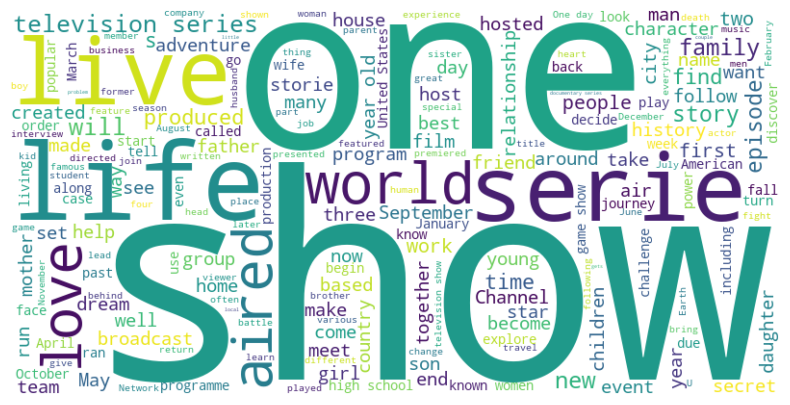

In [9]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Sample text data
text = ' '.join(df_my_started['overview'].dropna())

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Display the WordCloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

In [8]:
import pandas as pd
from textblob import TextBlob

ModuleNotFoundError: No module named 'textblob'

In [171]:
# sentiment is any( linear or polynomial) relation to popularity 
# I will try using simple linear regression to check if there is such using: Linear or poly with a higher degree 
# resolution there is no such - scatter between calc_popularity and given feature popularity doesn't yield anything.

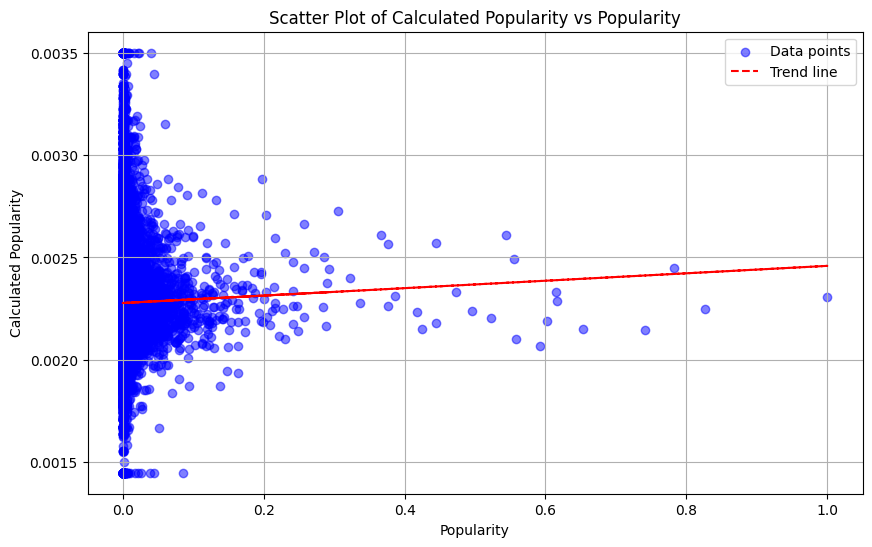

In [173]:
processed_df_lin = process_overview_df(df_my_started, 'overview')
plot_popularity_scatter(processed_df_lin)


In [174]:
# Process the DataFrame

processed_df = process_overview_df_with_polynomial(df_my_started, 'overview', degree=3)
# plot_distributions(df_processed)



# By transforming the original features into polynomial features and fitting a linear regression model to these transformed features, you can effectively model non-linear relationships in your data.
# This approach provides a flexible and powerful way to capture complex patterns and improve prediction accuracy.




In [175]:
processed_df

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time,sentiment,subjectivity,poly_calc_popularity
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,...,en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0,-0.080000,0.480000,9.822813
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,...,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70,-0.046032,0.560317,10.149571
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,...,en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0,-0.231548,0.530952,10.398328
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,...,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42,0.091667,0.291667,8.562572
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,...,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45,-0.351111,0.737778,11.388979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168629,238172,Bear Video Theater,1,24,en,0,9.000,Join legendary archer Fred Bear and fellow hun...,False,/zgLxmCAu8hthWr0k5KCyxjp4xIX.jpg,...,NaN,NaN,US,NaN,NaN,NaN,0,0.001852,0.494444,9.631857
168631,240608,Art Adore En,1,1,th,0,0.000,Pretty-faced art student Nong Hin is admired a...,False,/6e1GOC1spLbayeCMH8Y2AHrk6Ag.jpg,...,th,NaN,TH,ภาษาไทย,NaN,Thailand,0,0.250000,0.375000,8.100258
168632,240609,Born to Be Y,1,1,th,0,0.000,The story of 14 contestants who audition to co...,False,/rfZx8RZEfNcUNNu91qCIeRZ2x4i.jpg,...,th,GMM 25,TH,ภาษาไทย,NaN,Thailand,0,0.165097,0.448214,8.740654
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",False,/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,...,bn,NaN,IN,বাংলা,NaN,India,0,0.500000,0.500000,7.384777


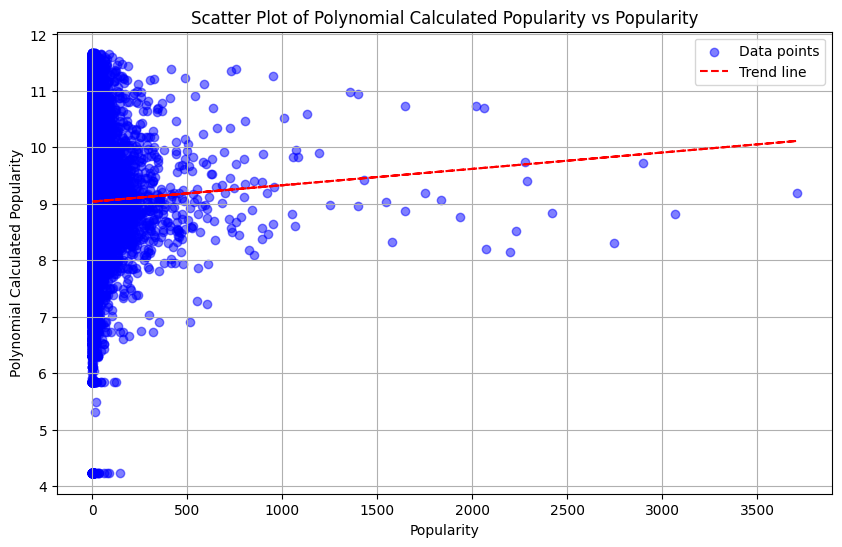

In [176]:
#print the catter plot of calc popularity Vs given popularity
plot_popularity_scatter_with_poly(processed_df)



In [177]:
processed_df.columns

Index(['id', 'name', 'number_of_seasons', 'number_of_episodes',
       'original_language', 'vote_count', 'vote_average', 'overview', 'adult',
       'backdrop_path', 'first_air_date', 'last_air_date', 'homepage',
       'in_production', 'original_name', 'popularity', 'poster_path', 'type',
       'status', 'tagline', 'genres', 'created_by', 'languages', 'networks',
       'origin_country', 'spoken_languages', 'production_companies',
       'production_countries', 'episode_run_time', 'sentiment', 'subjectivity',
       'poly_calc_popularity'],
      dtype='object')

In [178]:
processed_df

,id,name,number_of_seasons,number_of_episodes,original_language,vote_count,vote_average,overview,adult,backdrop_path,...,languages,networks,origin_country,spoken_languages,production_companies,production_countries,episode_run_time,sentiment,subjectivity,poly_calc_popularity
0,1399,Game of Thrones,8,73,en,21857,8.442,Seven noble families fight for control of the ...,False,/2OMB0ynKlyIenMJWI2Dy9IWT4c.jpg,...,en,HBO,US,English,"Revolution Sun Studios, Television 360, Genera...","United Kingdom, United States of America",0,-0.080000,0.480000,9.822813
1,71446,Money Heist,3,41,es,17836,8.257,"To carry out the biggest heist in history, a m...",False,/gFZriCkpJYsApPZEF3jhxL4yLzG.jpg,...,es,"Netflix, Antena 3",ES,Español,Vancouver Media,Spain,70,-0.046032,0.560317,10.149571
2,66732,Stranger Things,4,34,en,16161,8.624,"When a young boy vanishes, a small town uncove...",False,/2MaumbgBlW1NoPo3ZJO38A6v7OS.jpg,...,en,Netflix,US,English,"21 Laps Entertainment, Monkey Massacre Product...",United States of America,0,-0.231548,0.530952,10.398328
3,1402,The Walking Dead,11,177,en,15432,8.121,Sheriff's deputy Rick Grimes awakens from a co...,False,/x4salpjB11umlUOltfNvSSrjSXm.jpg,...,en,AMC,US,English,"AMC Studios, Circle of Confusion, Valhalla Mot...",United States of America,42,0.091667,0.291667,8.562572
4,63174,Lucifer,6,93,en,13870,8.486,"Bored and unhappy as the Lord of Hell, Lucifer...",False,/aDBRtunw49UF4XmqfyNuD9nlYIu.jpg,...,en,"FOX, Netflix",US,English,"Warner Bros. Television, DC Entertainment, Jer...",United States of America,45,-0.351111,0.737778,11.388979
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168629,238172,Bear Video Theater,1,24,en,0,9.000,Join legendary archer Fred Bear and fellow hun...,False,/zgLxmCAu8hthWr0k5KCyxjp4xIX.jpg,...,NaN,NaN,US,NaN,NaN,NaN,0,0.001852,0.494444,9.631857
168631,240608,Art Adore En,1,1,th,0,0.000,Pretty-faced art student Nong Hin is admired a...,False,/6e1GOC1spLbayeCMH8Y2AHrk6Ag.jpg,...,th,NaN,TH,ภาษาไทย,NaN,Thailand,0,0.250000,0.375000,8.100258
168632,240609,Born to Be Y,1,1,th,0,0.000,The story of 14 contestants who audition to co...,False,/rfZx8RZEfNcUNNu91qCIeRZ2x4i.jpg,...,th,GMM 25,TH,ภาษาไทย,NaN,Thailand,0,0.165097,0.448214,8.740654
168636,240696,Picasso,1,1,bn,0,0.000,"Murder, art and a journalist's relentless ques...",False,/fseBBbvHtdcZS5M7bSjOxYsVe5.jpg,...,bn,NaN,IN,বাংলা,NaN,India,0,0.500000,0.500000,7.384777


In [179]:
# Feature selection  ע”י מודלים לניבוי Lasso, Ridge

In [180]:
# ANOVA, T-tests, Lasso, Ridge, etc., to identify important features.

In [181]:
dfload1.columns


Index(['Mul_count_average_vote', 'episode_run_time', 'origin_continent',
       'v_network', 'id', 'Encoded_first_air_date_Year',
       'Encoded_first_air_date_M', 'Encoded_first_air_date_D',
       'Encoded_spoken_languages_cnt', 'Is_en_in_spoken_languages',
       'Encoded_languages_freq', 'Encoded_genres_freq',
       'Encoded_spoken_languages_freq', 'Encoded_v_adult', 'Encoded_status',
       'seasons_category', 'combined_category', 'popularity',
       'episodes_category', 'episodes_category_encoded',
       'Encoded_popularity_binned', 'Encoded_popularity_binned_encoded'],
      dtype='object')

In [182]:
dfload1.info()

In [183]:
# Inspect the dtypes and unique values for relevant columns
#print(dfload1[['popularity', 'first_air_date_M', 'first_air_date_D', 'first_air_date_Year']].dtypes)
#print(dfload1[['popularity', 'first_air_date_M', 'first_air_date_D', 'first_air_date_Year']].nunique())


In [184]:
# Apply the function
results_df = analyze_features(dfload1)
results_df


#     df['combined_category'] = df['seasons_category'].astype(str) + ' & ' + df['episodes_category'].astype(str)


,Feature,DType,Analysis Result,Recommended Method
Mul_count_average_vote,Mul_count_average_vote,float64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
episode_run_time,episode_run_time,float64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
origin_continent,origin_continent,float64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
v_network,v_network,float64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
id,id,int64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
Encoded_first_air_date_Year,Encoded_first_air_date_Year,category,Categorical,"Chi-Square Test, Logistic Regression"
Encoded_first_air_date_M,Encoded_first_air_date_M,category,Categorical,"Chi-Square Test, Logistic Regression"
Encoded_first_air_date_D,Encoded_first_air_date_D,category,Categorical,"Chi-Square Test, Logistic Regression"
Encoded_spoken_languages_cnt,Encoded_spoken_languages_cnt,category,Categorical,"Chi-Square Test, Logistic Regression"
Is_en_in_spoken_languages,Is_en_in_spoken_languages,category,Categorical,"Chi-Square Test, Logistic Regression"


In [185]:
dfload1['origin_continent'].value_counts()

5.0    28237
2.0    17369
3.0    11943
1.0     4712
0.0      557
4.0      546
Name: origin_continent, dtype: int64

In [186]:
dfload1['v_network'].value_counts()

4.0    51499
2.0     7015
1.0     2365
0.0     2006
3.0      479
Name: v_network, dtype: int64

In [187]:
dfload1['episode_run_time'].value_counts()

0.0     32830
45.0     4154
60.0     2238
30.0     2197
50.0     1459
        ...  
64.2        1
2.6         1
38.2        1
24.6        1
7.6         1
Name: episode_run_time, Length: 292, dtype: int64

In [188]:
dfload1['Mul_count_average_vote'].value_counts()


0.000000    37955
0.000069     2413
0.000055     2248
0.000048     1459
0.000083     1186
            ...  
0.024586        1
0.024421        1
0.021272        1
0.024146        1
0.013256        1
Name: Mul_count_average_vote, Length: 1146, dtype: int64

In [189]:
dfload1['popularity'].value_counts()

1.00    38932
2.00     7318
3.00     3811
4.00     2414
5.00     1741
        ...  
1.18        2
1.21        1
5.91        1
5.89        1
1.07        1
Name: popularity, Length: 490, dtype: int64

In [190]:
# from sklearn.preprocessing import PowerTransformer

# # Apply Yeo-Johnson Transformation
# pt = PowerTransformer(method='yeo-johnson')
# dfload1['Mul_count_average_vote_yeojohnson'] = pt.fit_transform(dfload1[['Mul_count_average_vote']])

# # Plot the transformed data
# plt.figure(figsize=(10, 6))
# sns.histplot(dfload1['Mul_count_average_vote_yeojohnson'], bins=30, kde=True)
# plt.title('Yeo-Johnson Transformed Distribution of Mul_count_average_vote')
# plt.xlabel('Yeo-Johnson(Mul_count_average_vote)')
# plt.ylabel('Frequency')
# plt.show()

# not used due to no reason comment all 
# dfload1 = dfload1.drop(columns=['Mul_count_average_vote_yeojohnson'])


In [191]:
# due to limitation on the items it should be categorial.
dfload1['origin_continent'] = dfload1['origin_continent'].astype('category')
dfload1['v_network'] = dfload1['v_network'].astype('category')

In [192]:
# Apply the function
results_df = analyze_features(dfload1)
results_df


,Feature,DType,Analysis Result,Recommended Method
Mul_count_average_vote,Mul_count_average_vote,float64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
episode_run_time,episode_run_time,float64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
origin_continent,origin_continent,category,Categorical,"Chi-Square Test, Logistic Regression"
v_network,v_network,category,Categorical,"Chi-Square Test, Logistic Regression"
id,id,int64,Non-Normal Continuous Numeric,"PCA, ICA, Lasso Regression, Ridge Regression"
Encoded_first_air_date_Year,Encoded_first_air_date_Year,category,Categorical,"Chi-Square Test, Logistic Regression"
Encoded_first_air_date_M,Encoded_first_air_date_M,category,Categorical,"Chi-Square Test, Logistic Regression"
Encoded_first_air_date_D,Encoded_first_air_date_D,category,Categorical,"Chi-Square Test, Logistic Regression"
Encoded_spoken_languages_cnt,Encoded_spoken_languages_cnt,category,Categorical,"Chi-Square Test, Logistic Regression"
Is_en_in_spoken_languages,Is_en_in_spoken_languages,category,Categorical,"Chi-Square Test, Logistic Regression"


In [193]:
import pandas as pd
from dataprep.eda import create_report

# Create a profile report
report = create_report(dfload1)

# Save the report to an HTML file
report.save('reportFeatureSelection_PRE.html')

  0%|                                                                                         | 0/2419 [00:00<…

C:\Users\DELL\AppData\Local\pypoetry\Cache\virtualenvs\myproject310-5HI4FQov-py3.10\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
C:\Users\DELL\AppData\Local\pypoetry\Cache\virtualenvs\myproject310-5HI4FQov-py3.10\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.DataFrame({col: [nrows - npresent]}, index=["Others"]))
C:\Users\DELL\AppData\Local\pypoetry\Cache\virtualenvs\myproject310-5HI4FQov-py3.10\lib\site-packages\dataprep\eda\distribution\render.py:274: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(pd.

In [194]:
# Assuming 'df' is your DataFrame and 'target_feature' is the name of your target column
# The Pearson correlation results you've provided show the strength and direction of the linear relationship between each feature and the target feature.
# Here’s how to interpret the values:

# numeric non -normal  \ non parametic 
spearman_results_df = calculate_spearman(dfload1, 'popularity')
spearman_results_df

# Understanding the Values
# Closer to 1 or -1: Indicates a stronger linear relationship.
# Closer to 0: Indicates a weaker or no linear relationship.
# Positive values: Indicate that as one variable increases, the other tends to increase.
# Negative values: Indicate that as one variable increases, the other tends to decrease.

,Feature,Spearman_Correlation
0,Mul_count_average_vote,0.610318
1,episode_run_time,0.344262
2,id,-0.203026


In [195]:
mann_whitney_results_df = calculate_mann_whitney(dfload1, 'popularity')
mann_whitney_results_df

,Group Feature,Mann-Whitney U Statistic,p-Value
0,Is_en_in_spoken_languages,434318140.5,0.003512


In [196]:
# Summary Table of Statistical Analyses
# Feature	ANOVA F-Statistic	ANOVA p-Value	Spearman Correlation	PCA Principal Component	PCA Explained Variance Ratio	PCA Cumulative Variance Ratio	Mann-Whitney U Statistic	Mann-Whitney p-Value	Conclusion
# Mul_count_average_vote	19.871137	0.0	0.610451	PC1	0.443031	0.443031	434300924.0	0.00341	Significant impact on the target feature.
# episode_run_time	16.260196	0.0	0.345183	PC2	0.326460	0.769491			Moderate impact based on correlation and PCA.
# id	8.596875	0.0	-0.202976	PC3	0.230509	1.000000			Lesser impact compared to other features.


# How to Interpret the Table:
# ANOVA:

# F-Statistic: Indicates the ratio of variance between groups to variance within groups. Higher values suggest a more significant effect on the target feature.
# p-Value: Values close to 0 indicate a statistically significant impact on the target variable.
# Spearman Correlation:

# Measures rank correlation. Positive values indicate a positive monotonic relationship with the target variable, while negative values indicate a negative monotonic relationship.
# PCA:

# Principal Component: Indicates the component that captures the most variance in the data.
# Explained Variance Ratio: Fraction of the total variance explained by each principal component.
# Cumulative Variance Ratio: Total variance explained by the principal components up to and including a given component.
# Mann-Whitney U Test:

# U Statistic: Reflects the difference between ranks in the two groups being compared.
# p-Value: Indicates whether there is a significant difference between the groups defined by the group feature.
# Conclusion:

# Summarizes the impact and significance of each feature based on the results from ANOVA, Spearman correlation, PCA, and the Mann-Whitney U Test.

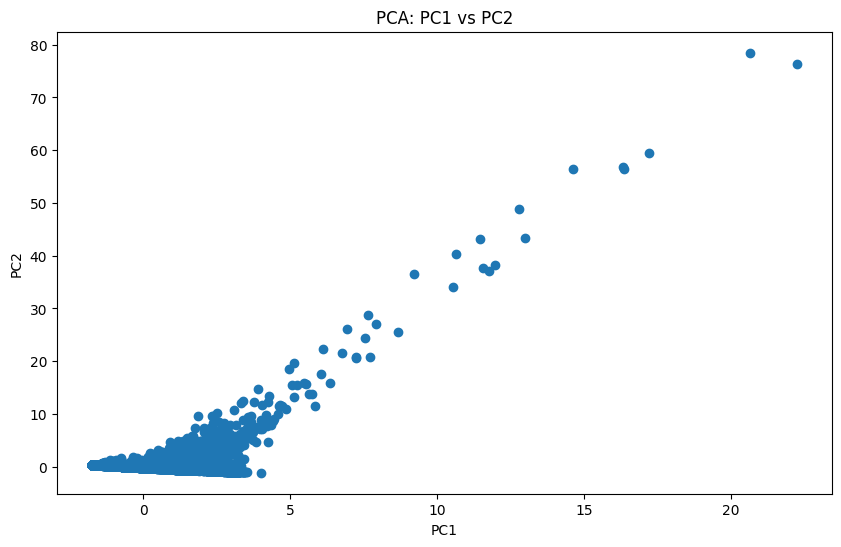

,Principal Component,Explained Variance Ratio,Cumulative Variance Ratio
0,PC1,0.442963,0.442963
1,PC2,0.326459,0.769422
2,PC3,0.230578,1.000000


In [197]:
target_feature = 'popularity'  # Specify your target feature
pca_results_df = perform_pca(dfload1, target_feature)

pca_results_df



# Features with high loadings (positive or negative) on a principal component have a significant influence on that component.
# For instance, Mul_count_average_vote heavily influences PC2, while episode_run_time and id are significant for PC3.

In [199]:
# Conclusion from all the three tehcnics
#Final Conclusion:

# 1 ANOVA Results:

    # All features show significant differences with respect to the target variable (p-value = 0.0), indicating they are important predictors in the regression model.
# 2 Pearson Correlation:

    # Mul_count_average_vote and episode_run_time have positive correlations with the target feature, indicating a direct relationship.
    # id shows a weak negative correlation, suggesting a slight inverse relationship with the target feature.


# 3 PCA Loadings:

    # Mul_count_average_vote heavily influences PC2, making it significant for capturing variance in this component.
    # episode_run_time and id have strong contributions to PC3 and PC1 respectively, showing their importance in these components.

# Integrated Insight:
    # Mul_count_average_vote is a significant feature according to ANOVA and has a strong impact on PC2. It shows a moderate positive correlation with the target variable.
    # episode_run_time is also significant in ANOVA and strongly affects PC3. It has a moderate positive correlation with the target variable.
    # id is significant in ANOVA and strongly affects both PC1 and PC3, but shows a weak negative correlation with the target variable.

In [200]:
#df_anova

In [201]:
# Analyze features
feature_cols = ['Encoded_spoken_languages_cnt', 'Encoded_languages_freq', 'Encoded_spoken_languages_freq']
anova_results, spearman_results, lasso_results = analyze_category_ordinalFeature(dfload1, 'popularity', feature_cols)

In [202]:
# Summary:
# ANOVA: Encoded_languages_freq and Encoded_spoken_languages_freq have high F-Statistics and low P-Values, indicating strong significance in predicting the target variable. Encoded_spoken_languages_cnt is less significant but still notable.

# Spearman’s Rank Correlation: Encoded_languages_freq shows a significant negative correlation with the target, while Encoded_spoken_languages_cnt and Encoded_spoken_languages_freq have weak or non-significant correlations.

# Lasso Regression: Encoded_languages_freq has the most substantial negative coefficient, suggesting a notable impact on the model, while Encoded_spoken_languages_cnt is excluded (coefficient = 0). The Model MSE indicates reasonable prediction accuracy.

In [203]:
# I will remove Encoded_spoken_languages_cnt !!!    

In [204]:
# # Example usage: conflict 

target_feature = 'popularity'
cat_order = ['Encoded_spoken_languages_cnt', 'Encoded_languages_freq', 'Encoded_spoken_languages_freq']
analyze_categorical_non_ordinal(dfload1, target_feature, cat_order)
analyze_categorical_non_ordinal2(dfload1, target_feature, cat_order)

C:\Users\DELL\AppData\Local\pypoetry\Cache\virtualenvs\myproject310-5HI4FQov-py3.10\lib\site-packages\sklearn\preprocessing\_discretization.py:248: FutureWarning: In version 1.5 onwards, subsample=200_000 will be used by default. Set subsample explicitly to silence this warning in the mean time. Set subsample=None to disable subsampling explicitly.
  warnings.warn(


(                              Feature  Mutual Information  Action
 0                    origin_continent            0.012136    Keep
 1                           v_network            0.052522    Keep
 2         Encoded_first_air_date_Year            0.010245    Keep
 3            Encoded_first_air_date_M            0.006036  Remove
 4            Encoded_first_air_date_D            0.007523  Remove
 5           Is_en_in_spoken_languages            0.002079  Remove
 6                 Encoded_genres_freq            0.175435    Keep
 7                     Encoded_v_adult            0.001749  Remove
 8                      Encoded_status            0.046909    Keep
 9                    seasons_category            0.015568    Keep
 10                  combined_category            0.083148    Keep
 11                  episodes_category            0.080893    Keep
 12          episodes_category_encoded            0.080893    Keep
 13          Encoded_popularity_binned            0.001010  Re

In [205]:
# Final Decision:
# Keep: If the feature adds predictive value (as indicated by the R² score) and doesn't cause significant issues such as overfitting or multicollinearity, it's generally advisable to keep it.
# Remove: If the Chi-Square test shows a very strong association and you suspect that this feature might be leading to data leakage or redundancy, it might be wise to remove it.
# Recommendation: You might start by keeping the feature and observing the model's performance. If the model overfits or the feature doesn't add substantial value after further testing, you can consider removing it.

In [206]:
# # anova_results performs on categorical columns to test
# perform_anova(df, target_feature, analysis_results):

# anova_results = perform_anova(dfload1, 'popularity')
# print(anova_results)

In [207]:
# # Example usage:
# # Assuming df is your DataFrame and 'popularity' is your target column

# significant_features = ['episodes_category_encoded','Encoded_genres_freq',  'episode_run_time', 'Encoded_languages_freq', 'first_air_date_Year', 'Encoded_spoken_languages_freq','first_air_date_D','first_air_date_M' ]  # Features selected by ANOVA


# # Run validation
# lasso_features_df, mse_df = validate_features(dfload1, 'popularity', significant_features, alpha=10)  # Adjust alpha as needed

# # Display results
# print("Selected Features DataFrame:")
# print(lasso_features_df)
# print("\nMSE Results DataFrame:")
# print(mse_df)


In [208]:
# Remove from the conclusion of model selection 

# Drop the column 'Encoded_spoken_languages_cnt' from dfload1
dfload1 = dfload1.drop(columns=['Encoded_spoken_languages_cnt'])


In [209]:
# Save the modified DataFrame back to a pickle file
joblib.dump(dfload1, 'ReadyFromFeatureSelect_Eng.pkl')

['ReadyFromFeatureSelect_Eng.pkl']

In [210]:
import pandas as pd
import joblib
#load from pickle 
dfload1 = joblib.load('ReadyFromFeatureSelect_Eng.pkl')

In [211]:

# Save the DataFrame to a CSV file
dfload1.to_csv('ReadyFromFeatureSelect_Eng.csv', index=False)

In [212]:
import json

# Assuming dtype_dict contains your data types dictionary
dtype_dict = dfload1.dtypes.apply(lambda x: x.name).to_dict()

# Save the dictionary as a JSON file
with open('dtype_dict.json', 'w') as json_file:
    json.dump(dtype_dict, json_file)
    

In [213]:
recheck_and_print(dfload1)